<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Question-1" data-toc-modified-id="Question-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></span></li><li><span><a href="#Question-2" data-toc-modified-id="Question-2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></span></li><li><span><a href="#Question-3" data-toc-modified-id="Question-3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 3</a></span></li><li><span><a href="#Question-4" data-toc-modified-id="Question-4-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Question 4</a></span></li><li><span><a href="#Question-5" data-toc-modified-id="Question-5-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Question 5</a></span></li></ul></div>

In [45]:
import sys
sys.path.append("/Users/sidou/Desktop/gmda/gudhi/build/cython/")

import numpy as np
import pickle as pickle
import os
import gudhi
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA

path_data = r"/Users/sidou/Desktop/gmda/data"

%matplotlib inline

In [2]:
# Import data
f = open(os.path.join(path_data, "data_acc_rot.dat"),"rb")
data = pickle.load(f,encoding="latin1")
f.close()

data_A = np.array(data[0])
data_B = np.array(data[1])
data_C = np.array(data[2])

data_all = np.concatenate([data_A, data_B, data_C])
label = data[3]

### Question 1
Compute and save the 0-dimensional and 1-dimensional persistence diagrams of the Rips fitrations (or alternately the alpha-shape filtrations) built on top of each of the 300 point clouds in R3.

In [3]:
point_cloud = data_A[0]
point_cloud_list = [list(coordinates) for coordinates in point_cloud]

In [4]:
def rips_persistance_from_point_cloud(point_cloud, dim, min_persistence=0):
    l_point_cloud = [list(coordinates) for coordinates in point_cloud]
    rips = gudhi.RipsComplex(points=l_point_cloud, max_edge_length=42)
    simplex_tree = rips.create_simplex_tree(max_dimension=dim)
    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=min_persistence)
    gudhi.plot_persistence_diagram(diag)

In [5]:
def alpha_persistance_from_point_cloud(point_cloud, min_persistence=0):
    alpha_complex = gudhi.AlphaComplex(points=point_cloud)
    simplex_tree = alpha_complex.create_simplex_tree(max_alpha_square=60.0)
    diag = simplex_tree.persistence(homology_coeff_field=2, min_persistence=min_persistence)
    return diag

In [6]:
def persistence_output_to_diag(persistence_output, dimension):
    return [[a,b] for (dim,(a,b)) in persistence_output if dim==dimension]

In [7]:
data_all[2].shape

(200, 3)

### Question 2
Compute the matrices of pairwise bottleneck distances between diagrams and use a dimensionality reduction algorithm to visualize them in 2D and 3D (e.g. Multidimensional Scaling).

In [9]:
def save_pairwise_btnck_dist(dimension, path):
    nb_individuals = data_all.shape[0]
    pairwise_btnck_dist = np.zeros((nb_individuals, nb_individuals))
    for i in tqdm_notebook(range(nb_individuals)):
        diag_i = persistence_output_to_diag(alpha_persistance_from_point_cloud(data_all[i]), dimension=dimension)
        for j in tqdm_notebook(range(i+1, nb_individuals)):
            diag_j = persistence_output_to_diag(alpha_persistance_from_point_cloud(data_all[j]), dimension=dimension)
            bottleneck_dist = gudhi.bottleneck_distance(diag_i, diag_j)
            pairwise_btnck_dist[i][j] = bottleneck_dist
            pairwise_btnck_dist[j][i] = bottleneck_dist
    pd.DataFrame(pairwise_btnck_dist).to_csv(os.path.join(path, "pairwise_btnck_dist_dim{}.csv".format(dimension)))

In [10]:
save_pairwise_btnck_dist(0, path_data)
save_pairwise_btnck_dist(1, path_data)

In [20]:
# Load pairwise bottleneck distances
pairwise_btnck_dist_dim0 = pd.read_csv(os.path.join(path_data, "pairwise_btnck_dist_dim0.csv")).drop('Unnamed: 0', axis=1)
pairwise_btnck_dist_dim1 = pd.read_csv(os.path.join(path_data, "pairwise_btnck_dist_dim1.csv")).drop('Unnamed: 0', axis=1)

In [85]:
# Visualize pairwise matrix for 0-dimensional persistance diagrams bottleneck distances
def reduce_and_visualize(pairwise_btnck_dist, dimension, n_components=2,):
    pca = PCA(n_components=n_components)
    pca.fit(pairwise_btnck_dist)
    red_pairwise_btnck_dist_dim0 = pca.transform(pairwise_btnck_dist)
    first_comp = red_pairwise_btnck_dist_dim0[:,0]
    second_comp = red_pairwise_btnck_dist_dim0[:,1]
    if n_components == 2:
        plt.plot(first_comp, second_comp, 'r.')
        plt.xlabel('Principal component')
        plt.ylabel('Second component')
        plt.title('2-D Reduced bottleneck distances for {}-dimensional persistance diagram'.format(dimension))
    elif n_components == 3:
        third_comp = red_pairwise_btnck_dist_dim0[:,2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(first_comp, second_comp, third_comp, c='r', marker='.')
        ax.set_xlabel('Principal component')
        ax.set_ylabel('Second component')
        ax.set_zlabel('Third component')
        plt.title('3-D Reduced bottleneck distances for {}-dimensional persistance diagram'.format(dimension))
    else:
        print("Too many dimensions to be visualized!")

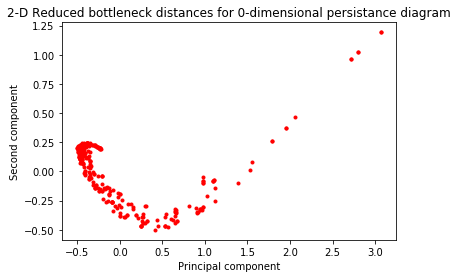

In [87]:
reduce_and_visualize(pairwise_btnck_dist_dim0, 0, n_components=2)

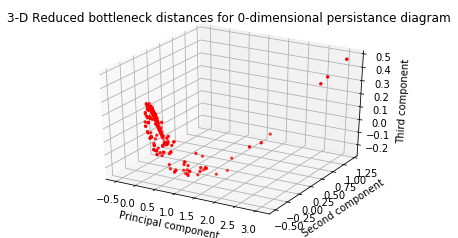

In [86]:
reduce_and_visualize(pairwise_btnck_dist_dim0, 0, n_components=3)

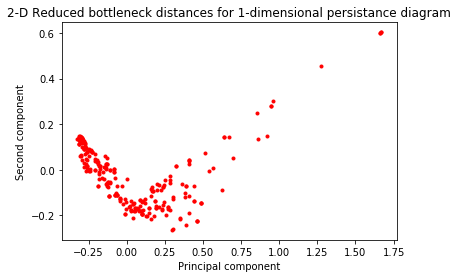

In [88]:
reduce_and_visualize(pairwise_btnck_dist_dim1, 1, n_components=2)

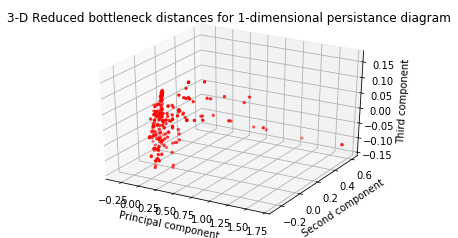

In [89]:
reduce_and_visualize(pairwise_btnck_dist_dim1, 1, n_components=3)

### Question 3
Write a function to compute persistence landscapes. This function should take as input a persistence diagram $dgm$ (in the Gudhi format), a dimension $k$, the endpoints $x_{min}; x_{max}$ of an interval, the number $n_{nodes}$
of nodes of a regular grid on the interval $[x_{min}; x_{max}]$ and a number of landscapes $n_{ld}$, and output a $n_{ld}*n_{nodes}$ array storing the values of the first $n_{ld}$ landscapes of $dgm$ on the node of the grid. Check, on some simple examples that your code is correct.

### Question 4
For each 0-dimensional and 1-dimensional persistence diagrams, compute the first 5 landscapes on a relevant interval with a few hundred of nodes. Splitting randomly the data set into a 80=20 learning/test data, use a random forest to explore the performances of the 0-dimensional or 1-dimensional landscapes to classify pedestrians. Compare the results you obtain using 0-dimensional landscapes, 1-dimensional landscapes or both.

### Question 5
Do the same experiment as previously, but using the raw data (3 × 200 array of acceleration coordinates). Compare the obtained classification results to the previous one.

In [13]:
print(type(data_A))
print("# individuals: {}".format(len(data_A)))
print("# points along a direction: {}".format(len(data_A[0])))
print("# of directions: {}".format(len(data_A[0][0])))

print("Example of 1 individual:\n {}".format(data_A[0]))

<class 'numpy.ndarray'>
# individuals: 100
# points along a direction: 200
# of directions: 3
Example of 1 individual:
 [[ -1.33597108e-02   2.03704449e+00   4.53778011e-01]
 [ -1.22212725e-01   9.84604407e-01   7.54364139e-01]
 [  5.96210366e-01   1.27607556e+00   2.52214017e-02]
 [  4.61930138e-01   5.50613865e-01   8.52447037e-01]
 [  3.64615934e-01   4.95419152e-01  -3.75068611e-01]
 [  1.48705618e-01   1.31868865e+00  -5.57132487e-01]
 [  1.21970218e-01   9.08640000e-01  -9.85069953e-02]
 [  4.24552220e-01   6.69800455e-01   2.49743836e-02]
 [  3.03482417e-01   8.40529068e-01  -1.61090176e-01]
 [  2.21348488e-01   8.82028647e-01  -8.70710108e-02]
 [  1.91261827e-01   9.89772405e-01   3.48958545e-02]
 [  1.10306464e-01   9.69843497e-01  -1.18117315e-01]
 [  1.99424980e-01   1.06387912e+00   4.68350993e-02]
 [  1.58980464e-01   1.13856814e+00  -1.10556181e-01]
 [  5.85603549e-02   1.19663888e+00  -3.98749347e-02]
 [  3.69446619e-01   1.47633793e+00  -9.48818849e-02]
 [  4.72592623e-

In [15]:
def flatten(data):
    list_result = [individual.flatten() for individual in data]
    return np.array(list_result)

In [16]:
# Flatten the list to get 100 rows of 600 points
flat_data_A = flatten(data_A)
print("# individuals: {}".format(len(flat_data_A)))
print("# points per individual: {}".format(len(flat_data_A[0])))

# individuals: 100
# points per individual: 600


In [17]:
# Concatenating data from 3 sources
flat_data_B = flatten(data_B)
flat_data_C = flatten(data_C)

X = np.concatenate((flat_data_A, flat_data_B, flat_data_C))
X.shape

(300, 600)

In [18]:
# Classifying using raw data
clf = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5)
print("Mean of cross-validation accuracy: {:.2f}".format(cross_val_score(clf, X, label, cv=cv, scoring='accuracy').mean()))

Mean of cross-validation accuracy: 0.93


In [19]:
# Test on 1 specific example from A
split = next(cv.split(X,label))
(X_train, y_train) = (X[split[0]], label[split[0]])
(X_test, y_test) = (X[split[1]], label[split[1]])

In [20]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [21]:
clf.predict(X_test)

array([b'A', b'B', b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A',
       b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'A', b'B', b'B',
       b'B', b'A', b'B', b'B', b'B', b'B', b'B', b'B', b'B', b'B', b'B',
       b'B', b'B', b'B', b'B', b'B', b'B', b'B', b'C', b'C', b'C', b'C',
       b'C', b'C', b'C', b'C', b'C', b'B', b'C', b'C', b'C', b'C', b'C',
       b'C', b'C', b'C', b'C', b'C'],
      dtype='|S1')